In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

from deep_feed_forward import *

## Creating Fake Data

In [2]:
N_EXAMPLES = 10000
N_DIM = 10
x = np.random.normal(0, 2, [N_EXAMPLES, N_DIM])
w = np.random.normal(0, 1, [N_DIM, 1])
y = np.matmul(x, w).flatten() + (x[:, 0] * x[:, 1] + x[:, 8] * x[:, 9])
y = 1/(1+np.exp(-y))
y = (np.random.rand(N_EXAMPLES) < y).astype('int32')

x_test = np.random.normal(0, 2, [500, N_DIM])
y_test = np.matmul(x_test, w).flatten() + (x_test[:, 0] * x_test[:, 1] + x_test[:, 8] * x_test[:, 9])
y_test = 1/(1+np.exp(-y_test))
y_test = (np.random.rand(500) < y_test).astype('int32')

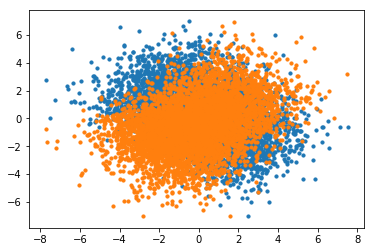

In [3]:
%matplotlib inline
plt.scatter(x[y==0, 0], x[y==0, 1], s=10)
plt.scatter(x[y==1, 0], x[y==1, 1], s=10)

## Set Up MLP

In [4]:
UNITS = [N_DIM, 256, 128, 64]
mlp = MultiLayerPerceptronWithProbes(units_per_layer=UNITS)
mlp.initialize()

In [5]:
STEPS = 40000
BATCH_SIZE = 10
CKPT_STEP = 400

losses = []
valids = []
for i in tqdm(range(STEPS)):
    batch_idx = np.random.choice(N_EXAMPLES, BATCH_SIZE)
    #batch_idx = np.arange(0, N_EXAMPLES)
    valids.append(mlp.get_loss(x_test, y_test))
    if i < STEPS/2:
        mode = 'all'
    else:
        mode = 'probe'
    loss = mlp.train_batch(x[batch_idx, :], y[batch_idx], mode=mode)
    losses.append(loss[:len(UNITS)+1])
losses = np.array(losses)

100%|██████████| 40000/40000 [01:12<00:00, 553.19it/s]


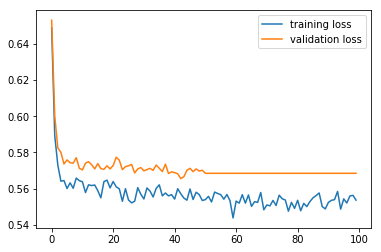

In [78]:
plt.plot(np.mean(np.reshape(np.array(losses[:, -1]), [STEPS/CKPT_STEP, CKPT_STEP]), axis=1))
plt.plot(np.mean(np.reshape(np.array(valids), [STEPS/CKPT_STEP, CKPT_STEP]), axis=1))
plt.legend(['training loss', 'validation loss'])
plt.show()

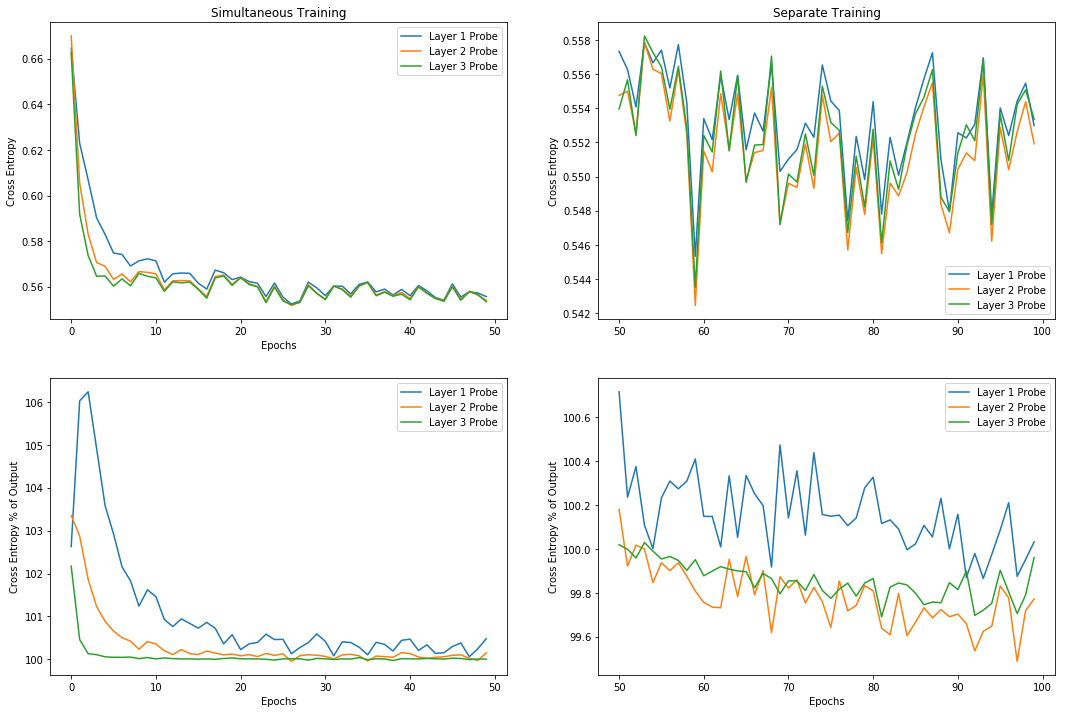

In [149]:
def smooth(ts, window):
    tot = len(ts)
    return np.mean(np.reshape(np.array(ts), [tot/window, window]), axis=1)

leg_list = ['Layer 1 Probe', 'Layer 2 Probe', 'Layer 3 Probe', 'Output loss']

fig, axes = plt.subplots(2, 2)
for i in range(1, len(UNITS)+1):
    smooth_ts = smooth(losses[:, i], CKPT_STEP)
    tot = len(smooth_ts)
    axes[0, 0].plot(range(tot/2), smooth_ts[:(tot/2)])
axes[0, 0].legend(leg_list)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Cross Entropy')

for i in range(1, len(UNITS)+1):
    smooth_ts = smooth(losses[:, i], CKPT_STEP)
    tot = len(smooth_ts)
    axes[0, 1].plot(range(tot/2, tot), smooth_ts[(tot/2):])
axes[0, 1].legend(leg_list)
axes[0, 1].set_ylabel('Cross Entropy')

for i in range(1, len(UNITS)+1):
    l = losses[:, i] / losses[:, -1] * 100
    smooth_ts = smooth(l, CKPT_STEP)
    tot = len(smooth_ts)
    axes[1, 0].plot(range(tot/2), smooth_ts[:(tot/2)])
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Cross Entropy % of Output')
axes[1, 0].legend(leg_list)

for i in range(1, len(UNITS)+1):
    l = losses[:, i] / losses[:, -1] * 100
    smooth_ts = smooth(l, CKPT_STEP)
    tot = len(smooth_ts)
    axes[1, 1].plot(range(tot/2, tot), smooth_ts[(tot/2):])
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Cross Entropy % of Output')
axes[1, 1].legend(leg_list)

axes[0, 0].set_title('Simultaneous Training')
axes[0, 1].set_title('Separate Training')

fig.set_size_inches(18, 2*6)
plt.show()

In [135]:
UNITS = [N_DIM, 256, 128, 64]
mlp1 = MultiLayerPerceptron(units_per_layer=UNITS)
mlp1.initialize()

STEPS = 20000

losses1 = []
valids1 = []
for i in tqdm(range(STEPS)):
    batch_idx = np.random.choice(N_EXAMPLES, BATCH_SIZE)
    #batch_idx = np.arange(0, N_EXAMPLES)
    valids1.append(mlp1.get_loss(x_test, y_test))
    loss = mlp1.train_batch(x[batch_idx, :], y[batch_idx])
    losses1.append(loss)

100%|██████████| 20000/20000 [00:33<00:00, 604.96it/s]


In [136]:
UNITS = [N_DIM, 256, 128]
mlp2 = MultiLayerPerceptron(units_per_layer=UNITS)
mlp2.initialize()

STEPS = 20000

losses2 = []
valids2 = []
for i in tqdm(range(STEPS)):
    batch_idx = np.random.choice(N_EXAMPLES, BATCH_SIZE)
    #batch_idx = np.arange(0, N_EXAMPLES)
    valids2.append(mlp2.get_loss(x_test, y_test))
    loss = mlp2.train_batch(x[batch_idx, :], y[batch_idx])
    losses2.append(loss)

100%|██████████| 20000/20000 [00:31<00:00, 643.92it/s]


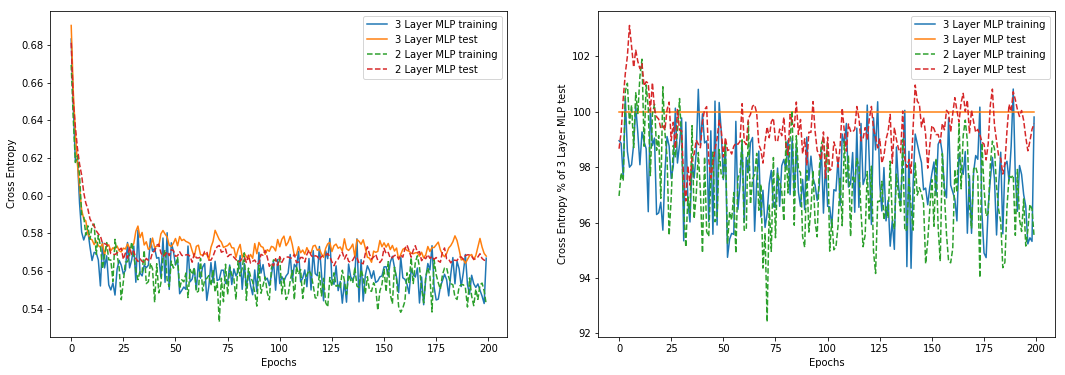

In [208]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(smooth(losses1, 100))
ax[0].plot(smooth(valids1, 100))
ax[0].plot(smooth(losses2, 100), '--')
ax[0].plot(smooth(valids2, 100), '--')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].legend(['3 Layer MLP training', '3 Layer MLP test', '2 Layer MLP training', '2 Layer MLP test'])

smooth_ts = smooth(valids1, 100)
ax[1].plot(smooth(losses1, 100)/smooth_ts*100)
ax[1].plot(smooth(valids1, 100)/smooth_ts*100)
ax[1].plot(smooth(losses2, 100)/smooth_ts*100, '--')
ax[1].plot(smooth(valids2, 100)/smooth_ts*100, '--')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Cross Entropy % of 3 Layer MLP test')
ax[1].legend(['3 Layer MLP training', '3 Layer MLP test', '2 Layer MLP training', '2 Layer MLP test'])
fig.set_size_inches(2*9, 6)

[0 8]
[0 9]
[8 9]
[8 1]


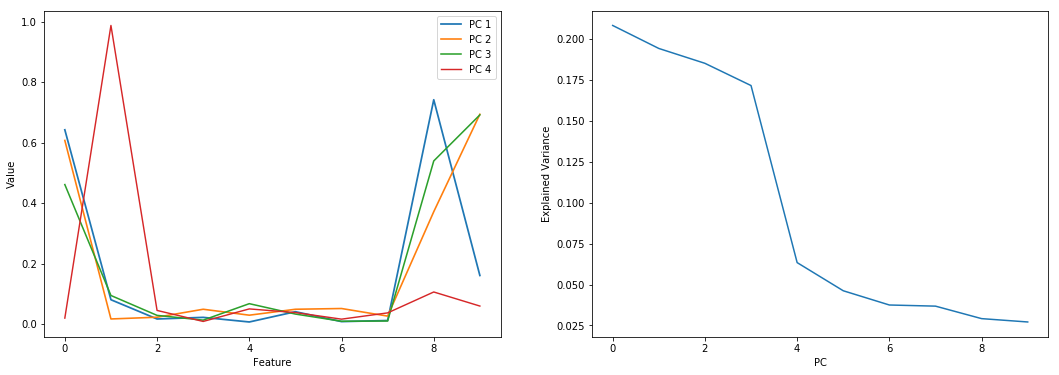

In [240]:
weight_list = mlp.get_layer_weights()

pca = PCA(n_components = N_DIM)
z = pca.fit_transform(weight_list[0].T)

#plt.scatter(z[:, 0], z[:, 1], s=10)
#plt.show()

fig, ax = plt.subplots(1, 2)

for i in xrange(4):
    ax[0].plot(range(10), np.abs(pca.components_[i]),
             linewidth=pca.explained_variance_[i] * 30)
    print np.argsort(np.abs(pca.components_[i]))[-2:]
ax[0].set_xlabel('Feature')
ax[0].set_ylabel('Value')
ax[0].legend(['PC 1', 'PC 2', 'PC 3', 'PC 4'])

ax[1].plot(pca.explained_variance_/np.sum(pca.explained_variance_))
ax[1].set_xlabel('PC')
ax[1].set_ylabel('Explained Variance')
fig.set_size_inches(2*9, 6)

In [ ]:
from itertools import combinations
import copy

def augment_data(x, feat_list):
    n_points = x.shape[0]
    new_x = copy.copy(x)
    n = len(feat_list)
    comb = combinations(feat_list, 2)
    for i in range(n*(n-1)/2):
        tup = comb.next()
        new_col = x[:, tup[0]] * x[:, tup[1]]
        new_col = np.reshape(new_col, [n_points, 1])
        new_x = np.append(new_x, new_col, axis=1)
    return new_x

In [218]:
x_new = augment_data(x, [0, 8, 9, 1])
x_test_new = augment_data(x_test, [0, 8, 9, 1])

UNITS = [N_DIM + 6, 256, 128]
mlp3 = MultiLayerPerceptron(units_per_layer=UNITS)
mlp3.initialize()

STEPS = 20000

losses3 = []
valids3 = []
for i in tqdm(range(STEPS)):
    batch_idx = np.random.choice(N_EXAMPLES, BATCH_SIZE)
    #batch_idx = np.arange(0, N_EXAMPLES)
    valids3.append(mlp3.get_loss(x_test_new, y_test))
    loss = mlp3.train_batch(x_new[batch_idx, :], y[batch_idx])
    losses3.append(loss)



  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 36/20000 [00:00<00:55, 357.06it/s]

  0%|          | 91/20000 [00:00<00:49, 398.26it/s]

  1%|          | 154/20000 [00:00<00:44, 446.54it/s]

  1%|          | 220/20000 [00:00<00:40, 493.74it/s]

  1%|▏         | 289/20000 [00:00<00:36, 537.96it/s]

  2%|▏         | 354/20000 [00:00<00:34, 565.28it/s]

  2%|▏         | 416/20000 [00:00<00:33, 579.29it/s]

  2%|▏         | 484/20000 [00:00<00:32, 604.80it/s]

  3%|▎         | 552/20000 [00:00<00:31, 623.04it/s]

  3%|▎         | 621/20000 [00:01<00:30, 639.52it/s]

  3%|▎         | 690/20000 [00:01<00:29, 652.46it/s]

  4%|▍         | 760/20000 [00:01<00:29, 661.69it/s]

  4%|▍         | 829/20000 [00:01<00:28, 669.25it/s]

  4%|▍         | 898/20000 [00:01<00:28, 672.22it/s]

  5%|▍         | 967/20000 [00:01<00:28, 674.90it/s]

  5%|▌         | 1035/20000 [00:01<00:28, 671.72it/s]

  6%|▌         | 1104/20000 [00:01<00:27, 676.50it/s]

  6%|▌         | 1173/20000 [00:01<00

 91%|█████████ | 18149/20000 [00:27<00:02, 687.80it/s]

 91%|█████████ | 18218/20000 [00:27<00:02, 688.19it/s]

 91%|█████████▏| 18287/20000 [00:27<00:02, 685.28it/s]

 92%|█████████▏| 18357/20000 [00:27<00:02, 689.09it/s]

 92%|█████████▏| 18427/20000 [00:27<00:02, 692.16it/s]

 92%|█████████▏| 18497/20000 [00:27<00:02, 691.70it/s]

 93%|█████████▎| 18567/20000 [00:27<00:02, 689.38it/s]

 93%|█████████▎| 18636/20000 [00:27<00:02, 679.34it/s]

 94%|█████████▎| 18704/20000 [00:27<00:01, 679.16it/s]

 94%|█████████▍| 18773/20000 [00:28<00:01, 679.23it/s]

 94%|█████████▍| 18843/20000 [00:28<00:01, 682.88it/s]

 95%|█████████▍| 18912/20000 [00:28<00:01, 676.07it/s]

 95%|█████████▍| 18982/20000 [00:28<00:01, 680.71it/s]

 95%|█████████▌| 19051/20000 [00:28<00:01, 668.16it/s]

 96%|█████████▌| 19118/20000 [00:28<00:02, 436.56it/s]

 96%|█████████▌| 19179/20000 [00:28<00:01, 475.93it/s]

 96%|█████████▌| 19247/20000 [00:28<00:01, 520.72it/s]

 97%|█████████▋| 19315/20000 [00:29<00:01, 558.4

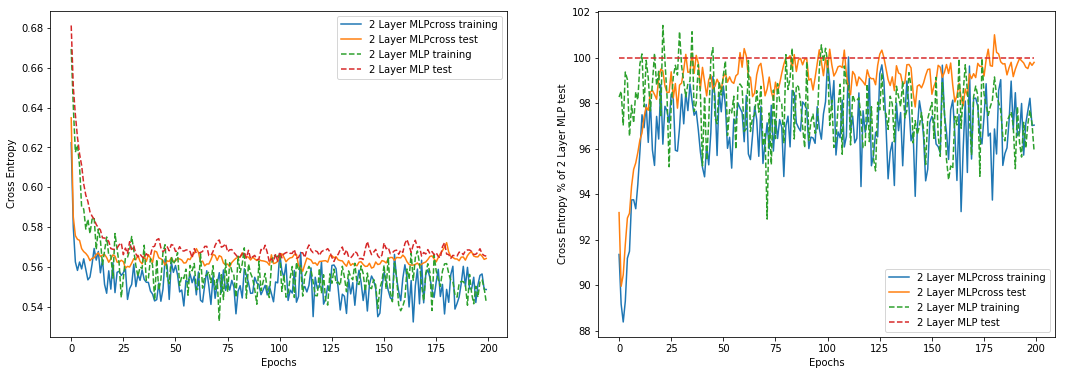

In [222]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(smooth(losses3, 100))
ax[0].plot(smooth(valids3, 100))
ax[0].plot(smooth(losses2, 100), '--')
ax[0].plot(smooth(valids2, 100), '--')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].legend(['2 Layer MLPcross training', '2 Layer MLPcross test', '2 Layer MLP training', '2 Layer MLP test'])

smooth_ts = smooth(valids2, 100)
ax[1].plot(smooth(losses3, 100)/smooth_ts*100)
ax[1].plot(smooth(valids3, 100)/smooth_ts*100)
ax[1].plot(smooth(losses2, 100)/smooth_ts*100, '--')
ax[1].plot(smooth(valids2, 100)/smooth_ts*100, '--')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Cross Entropy % of 2 Layer MLP test')
ax[1].legend(['2 Layer MLPcross training', '2 Layer MLPcross test', '2 Layer MLP training', '2 Layer MLP test'])
fig.set_size_inches(2*9, 6)